In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from tqdm import tqdm
from shutil import copyfile
import cv2

In [2]:
######################
### Load Luke Mean ###
######################

luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

#####################
### Load JFRC2018 ###
#####################

fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)

##################
### Load Atlas ###
##################

atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_reorient_transformed.nii"
atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')
atlas = ants.from_numpy(atlas)
atlas.set_spacing((.76,.76,.76))
atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)

In [3]:
################################
### Load voxel-res corr data ###
################################

dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210420_correlation/"
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
maps = {}
for behavior in behaviors:
    rvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'rvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(rvalues_to_load)

    pvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'pvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(pvalues_to_load)
    
    r_map = []
    p_map = []
    for z in range(49):
        r_map.append(np.load(rvalues_to_load[z]))
        p_map.append(np.load(pvalues_to_load[z]))

    r_map = np.asarray(r_map)
    p_map = np.asarray(p_map)
    
    r_map = np.reshape(r_map, (49,256,128))
    p_map = np.reshape(p_map, (49,256,128))
    
    r_map[p_map >= 1e-4]=0
    
    maps[behavior] = r_map
    
############################################
### Put into plotting format with colors ###
############################################

slices = []
for z in range(49):
    colors1 = maps['Z_neg'][z,:,:].T
    colors2 = maps['Z_pos'][z,:,:].T
    colors3 = maps['Y_pos'][z,:,:].T
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)
slices = np.asarray(slices)

func = np.swapaxes(slices, 0, 2)
func.shape

res_LUKE = (2.6, 2.6, 5, 1)
moving = ants.from_numpy(func[:,:,::-1,:])
moving.set_spacing(res_LUKE)

In [35]:
##################################
### Warp corr into atlas space ###
##################################

moving.set_spacing((2.6076, 2.6154, 5.3125, 1)) ### matching this to the slightly off luke mean
out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')
maps = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0], imagetype=3, interpolator='nearestNeighbor')

In [37]:
maps.shape

(314, 146, 91, 3)

In [38]:
314/2

157.0

In [39]:
####################
### Mirror Clean ###
####################

### Forward ###

left = maps.numpy()[:157,:,:,2]
right = maps.numpy()[157:,:,:,2]

right = right[::-1,:,:]

mask = np.logical_and(right!=0, left!=0)
mask.shape

LR_mean = np.mean(np.array([left,right]), axis=0)

mean_masked = LR_mean*mask

fwd = np.concatenate((mean_masked, mean_masked[::-1,:,:]), axis=0)

#plt.imshow(fwd[:,:,20])

### Rotation ###

left = maps.numpy()[::,:,:,0]
right = maps.numpy()[::-1,:,:,1]

mask = np.logical_and(right!=0, left!=0)
mask.shape

LR_mean = np.mean(np.array([left,right]), axis=0)

mean_masked = LR_mean*mask

rot = mean_masked

### combine back into color channels ###

mirrored_clean = np.concatenate((rot[::-1,:,:,np.newaxis], rot[...,np.newaxis], fwd[...,np.newaxis]),axis=-1)

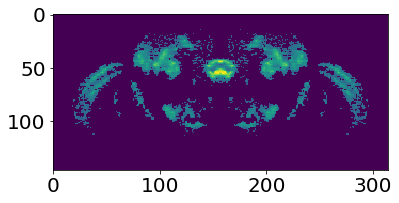

In [43]:
plt.imshow(mirrored_clean[:,:,60,2].T)

In [12]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from mpl_toolkits import mplot3d

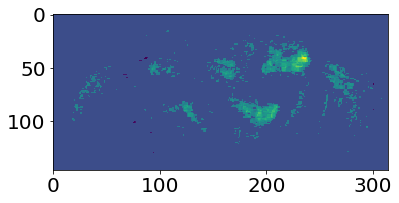

In [29]:
plt.imshow(maps_voxel_res.numpy()[:,:,60,0].T)

In [47]:
smo = gaussian_filter(mirrored_clean[:,:,:,0],sigma=2)

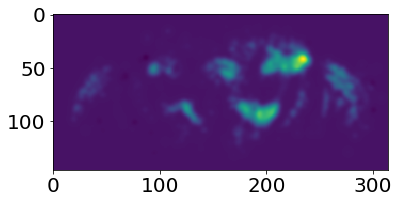

In [30]:
plt.imshow(smo[:,:,60].T)

(0, 0.01)

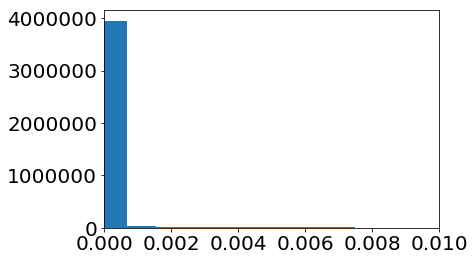

In [55]:
plt.hist(smo.flatten(),bins=100);
plt.xlim(0,.01)

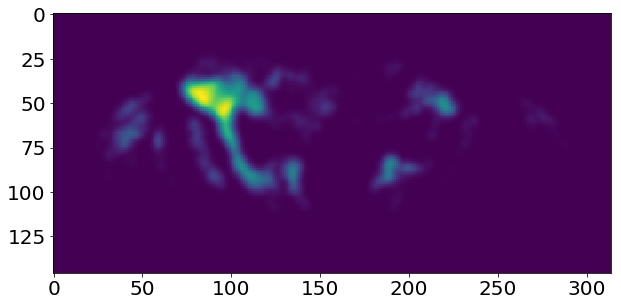

In [81]:
plt.figure(figsize=(10,10))
plt.imshow(smo[:,:,65].T)#,vmin=None,vmax=.001)

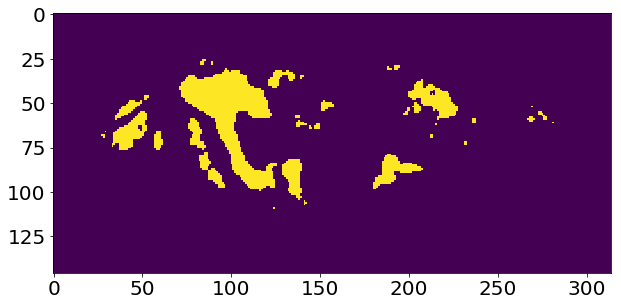

In [95]:
plt.figure(figsize=(10,10))
smo = gaussian_filter(mirrored_clean[:,:,:,0],sigma=1)
mask = np.zeros(smo.shape)
mask[np.where(smo>.005)]=1
plt.imshow(mask[:,:,65].T)

In [99]:
import trimesh

In [116]:
surf_mesh = trimesh.Trimesh(verts, faces, validate=True)
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210702_blender/fwd.stl'
surf_mesh.export(save_file)

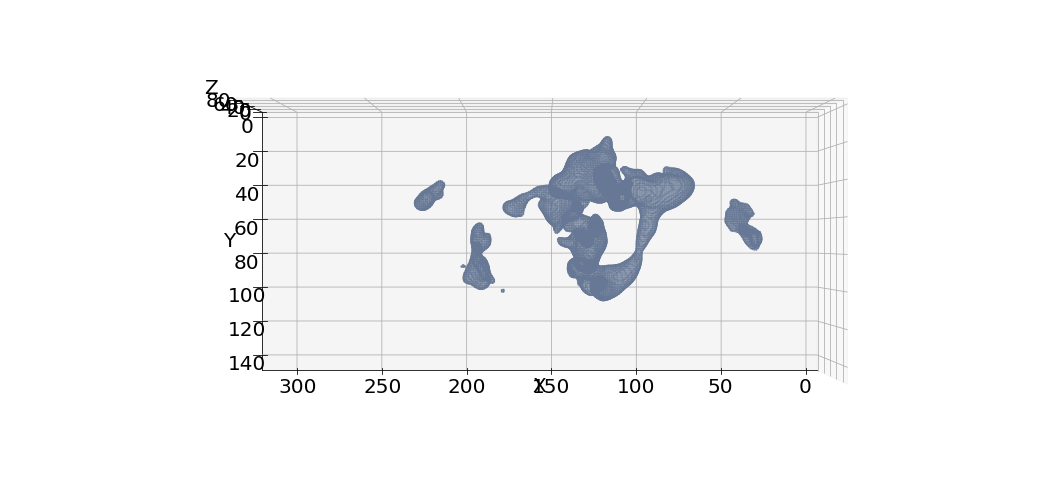

In [107]:
# Use marching cubes to obtain the iso-surface mesh
# smo = gaussian_filter(mirrored_clean[:,:,:,0],sigma=2)
# verts, faces, normals, values = measure.marching_cubes_lewiner(smo, 0.015)

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.set_aspect('equal')  

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_facecolor('#1f77b400')
#mesh.set_edgecolor('#1f77b430')
mesh.set_edgecolor('#66789630')
mesh.set_alpha(1)
ax.add_collection3d(mesh)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

#ax.view_init(elev=90, azim=90) # front view
#ax.view_init(elev=0, azim=90) # bottom view
#ax.view_init(elev=180, azim=90) # also bottom view, 180
ax.view_init(elev=90, azim=90)

# set_axes_equal(ax) 
ax.set_xlim(0, 314)
ax.set_ylim(0, 146)
ax.set_zlim(0, 91)

plt.tight_layout()
plt.show()

In [113]:
mirrored_clean.shape

(314, 146, 91, 3)

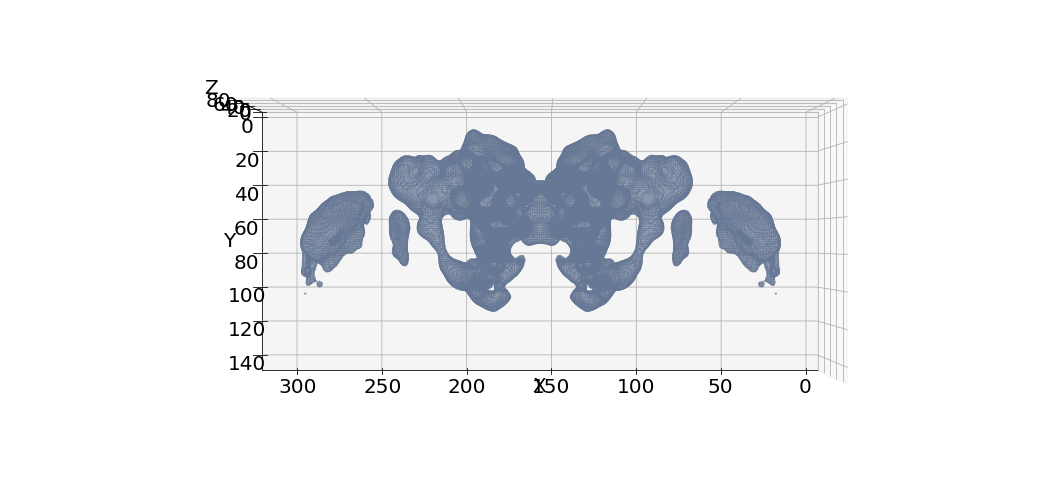

In [114]:
# Use marching cubes to obtain the iso-surface mesh
smo = gaussian_filter(mirrored_clean[:,:,:,2],sigma=2)
verts, faces, normals, values = measure.marching_cubes_lewiner(smo, 0.015)

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.set_aspect('equal')  

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_facecolor('#1f77b400')
#mesh.set_edgecolor('#1f77b430')
mesh.set_edgecolor('#66789630')
mesh.set_alpha(1)
ax.add_collection3d(mesh)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

#ax.view_init(elev=90, azim=90) # front view
#ax.view_init(elev=0, azim=90) # bottom view
#ax.view_init(elev=180, azim=90) # also bottom view, 180
ax.view_init(elev=90, azim=90)

# set_axes_equal(ax) 
ax.set_xlim(0, 314)
ax.set_ylim(0, 146)
ax.set_zlim(0, 91)

plt.tight_layout()
plt.show()

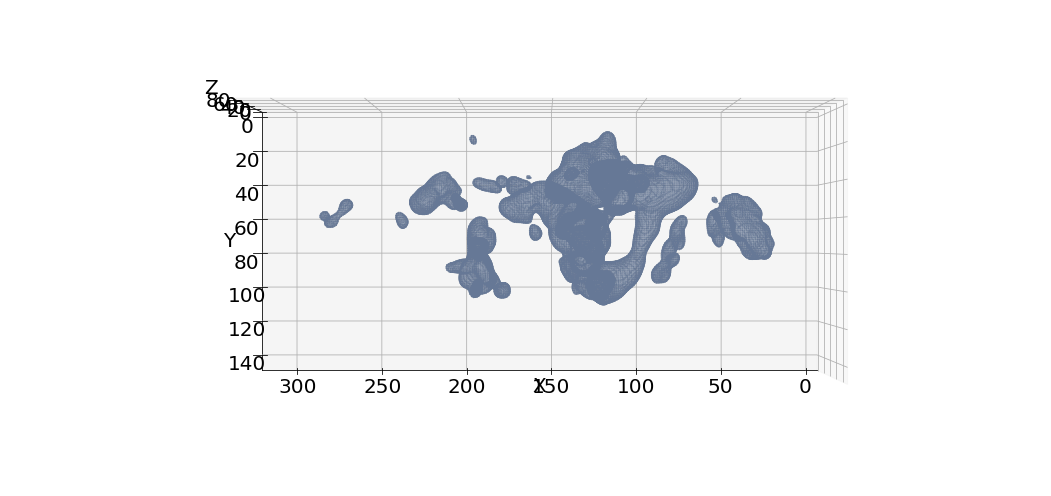

In [85]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.set_aspect('equal')  

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_facecolor('#1f77b400')
#mesh.set_edgecolor('#1f77b430')
mesh.set_edgecolor('#66789630')
mesh.set_alpha(1)
ax.add_collection3d(mesh)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

#ax.view_init(elev=90, azim=90) # front view
#ax.view_init(elev=0, azim=90) # bottom view
#ax.view_init(elev=180, azim=90) # also bottom view, 180
ax.view_init(elev=90, azim=90)

# set_axes_equal(ax) 
ax.set_xlim(0, 314)
ax.set_ylim(0, 146)
ax.set_zlim(0, 91)

plt.tight_layout()
plt.show()

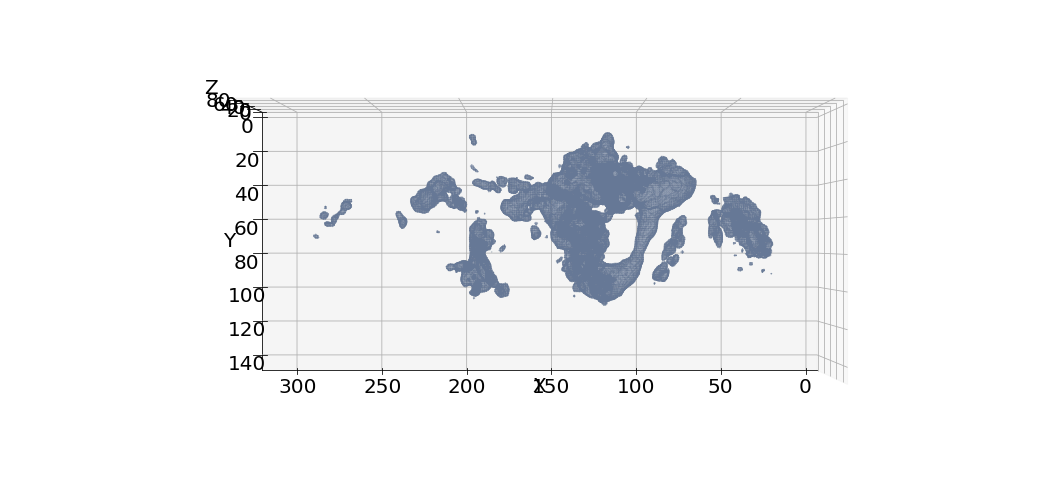

In [51]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.set_aspect('equal')  

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_facecolor('#1f77b400')
#mesh.set_edgecolor('#1f77b430')
mesh.set_edgecolor('#66789630')
mesh.set_alpha(1)
ax.add_collection3d(mesh)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

#ax.view_init(elev=90, azim=90) # front view
#ax.view_init(elev=0, azim=90) # bottom view
#ax.view_init(elev=180, azim=90) # also bottom view, 180
ax.view_init(elev=90, azim=90)

# set_axes_equal(ax) 
ax.set_xlim(0, 314)
ax.set_ylim(0, 146)
ax.set_zlim(0, 91)

plt.tight_layout()
plt.show()

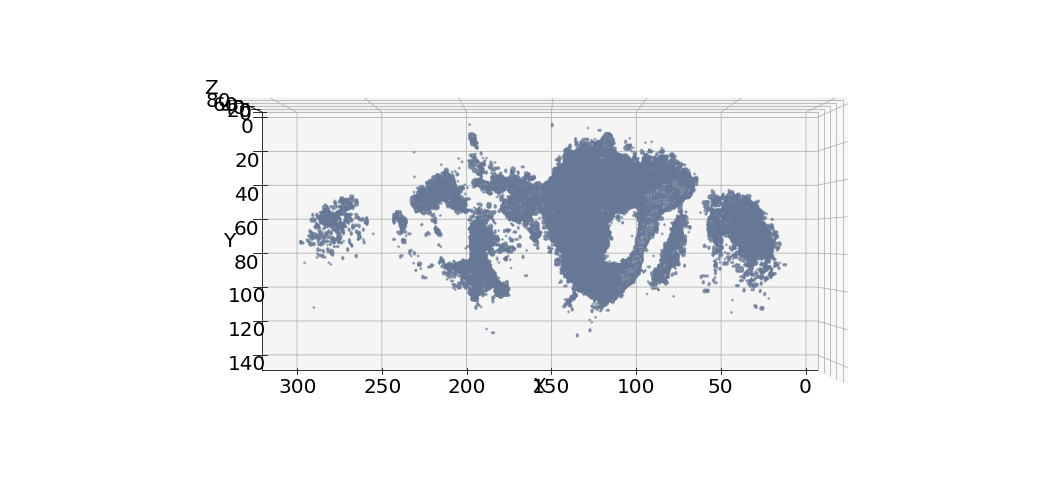

In [46]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.set_aspect('equal')  

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_facecolor('#1f77b400')
#mesh.set_edgecolor('#1f77b430')
mesh.set_edgecolor('#66789630')
mesh.set_alpha(1)
ax.add_collection3d(mesh)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

#ax.view_init(elev=90, azim=90) # front view
#ax.view_init(elev=0, azim=90) # bottom view
#ax.view_init(elev=180, azim=90) # also bottom view, 180
ax.view_init(elev=90, azim=90)

# set_axes_equal(ax) 
ax.set_xlim(0, 314)
ax.set_ylim(0, 146)
ax.set_zlim(0, 91)

plt.tight_layout()
plt.show()

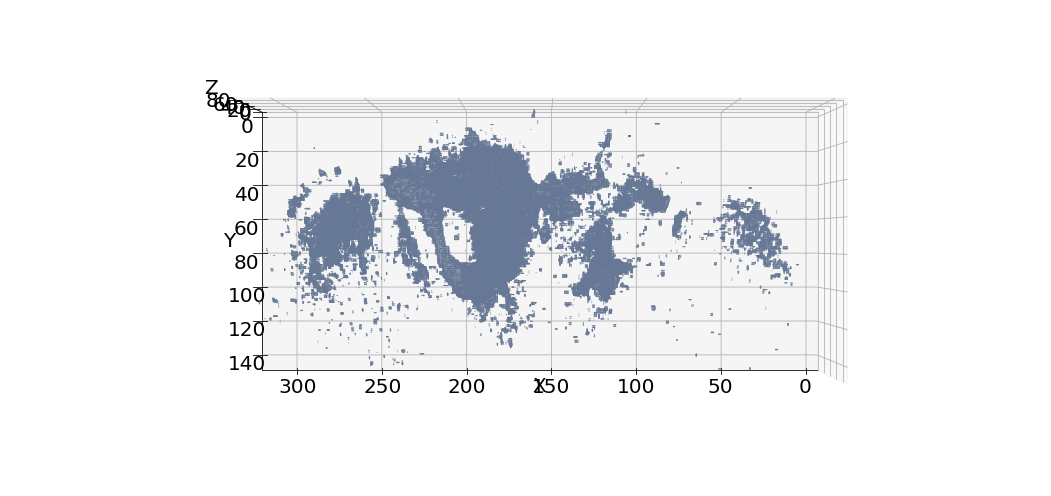

In [15]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.set_aspect('equal')  

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_facecolor('#1f77b400')
#mesh.set_edgecolor('#1f77b430')
mesh.set_edgecolor('#66789630')
mesh.set_alpha(1)
ax.add_collection3d(mesh)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

#ax.view_init(elev=90, azim=90) # front view
#ax.view_init(elev=0, azim=90) # bottom view
#ax.view_init(elev=180, azim=90) # also bottom view, 180
ax.view_init(elev=90, azim=90)

# set_axes_equal(ax) 
ax.set_xlim(0, 314)
ax.set_ylim(0, 146)
ax.set_zlim(0, 91)

plt.tight_layout()
plt.show()

# get meanbrain surface

In [133]:
luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210315_luke2jfrc_affine.nii"
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')

In [134]:
luke_mean.shape

(1652, 768, 479)

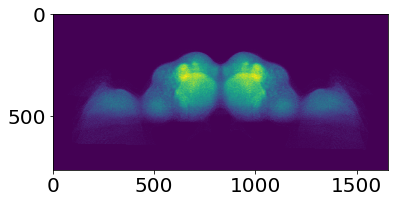

In [120]:
plt.imshow(luke_mean[:,:,100].T)

In [135]:
res_JRC2018 = (0.38, 0.38, 0.38)
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_JRC2018)
luke_mean_lowres = ants.resample_image(luke_mean,(2,2,2),use_voxels=False)

In [136]:
luke_mean_lowres.shape

(314, 146, 91)

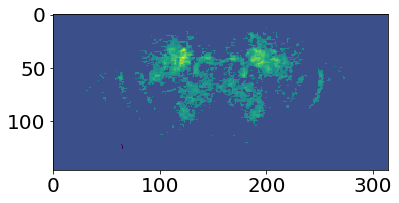

In [151]:
plt.imshow(maps_voxel_res.numpy()[:,:,75,2].T)

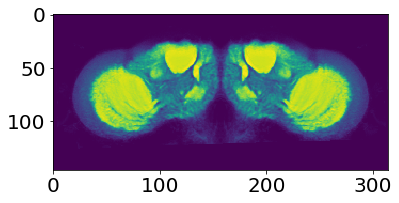

In [152]:
plt.imshow(luke_mean_lowres[:,:,75].T)

In [ ]:
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)

In [153]:
### Load Luke Mean ###

luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)

In [154]:
### Load JFRC2018 ###

fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)

In [155]:
### Down-sample jfrc to 2um isotropic
fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)

In [156]:
### down-sample luke_mean to func res
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

In [157]:
out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')

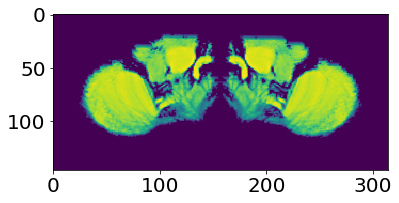

In [158]:
plt.imshow(out['warpedmovout'][:,:,75].T)

In [160]:
meanbrain = out['warpedmovout'].numpy()

(array([2834522.,   47514.,   46907.,  145868.,  202822.,  200133.,
         190135.,  195690.,  269823.,   38390.]),
 array([0.        , 0.10168055, 0.20336111, 0.30504166, 0.40672221,
        0.50840276, 0.61008332, 0.71176387, 0.81344442, 0.91512498,
        1.01680553]),
 <a list of 10 Patch objects>)

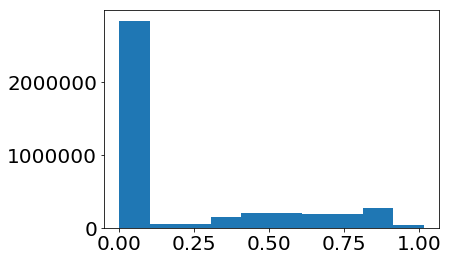

In [161]:
plt.hist(meanbrain.flatten())

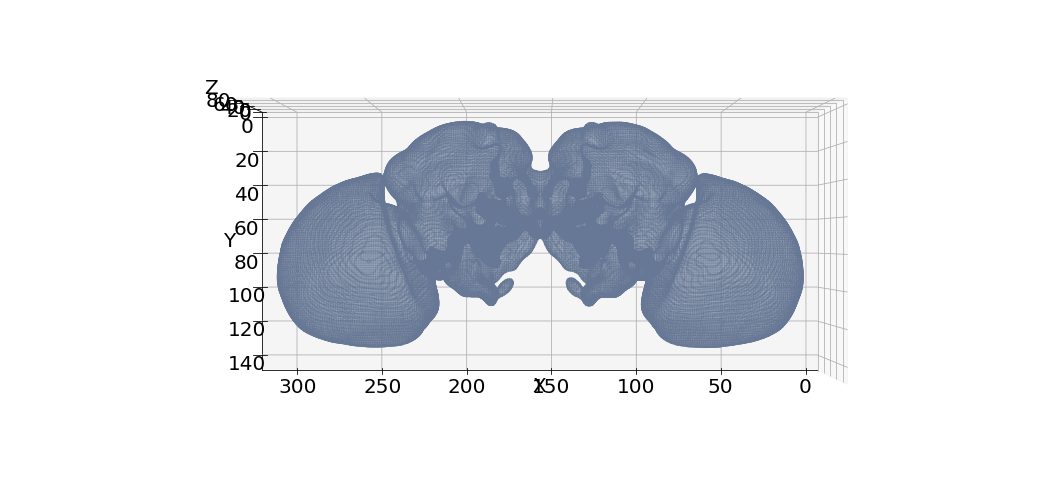

In [166]:
# Use marching cubes to obtain the iso-surface mesh
smo = gaussian_filter(meanbrain,sigma=2)
verts, faces, normals, values = measure.marching_cubes_lewiner(smo, 0.5)

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.set_aspect('equal')  

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_facecolor('#1f77b400')
#mesh.set_edgecolor('#1f77b430')
mesh.set_edgecolor('#66789630')
mesh.set_alpha(1)
ax.add_collection3d(mesh)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

#ax.view_init(elev=90, azim=90) # front view
#ax.view_init(elev=0, azim=90) # bottom view
#ax.view_init(elev=180, azim=90) # also bottom view, 180
ax.view_init(elev=90, azim=90)

# set_axes_equal(ax) 
ax.set_xlim(0, 314)
ax.set_ylim(0, 146)
ax.set_zlim(0, 91)

plt.tight_layout()
plt.show()

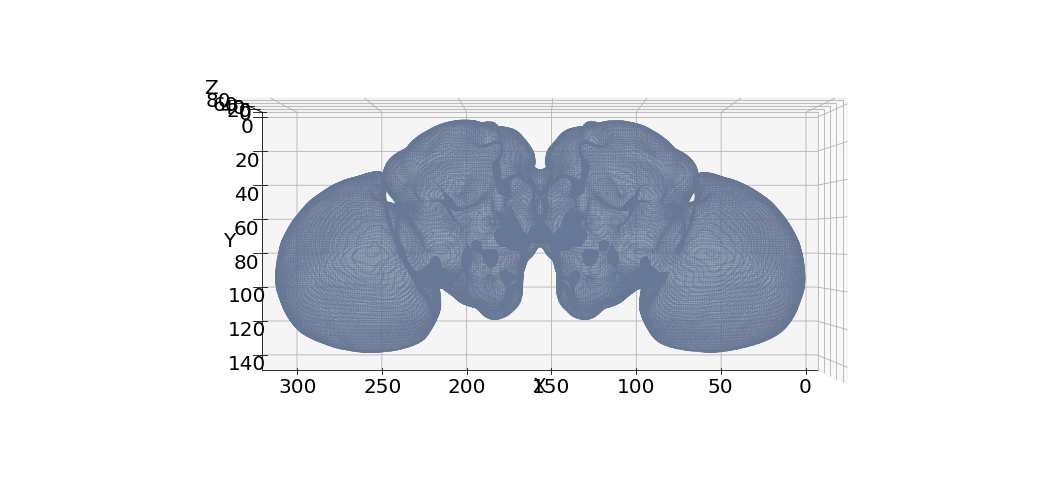

In [167]:
# Use marching cubes to obtain the iso-surface mesh
smo = gaussian_filter(meanbrain,sigma=2)
verts, faces, normals, values = measure.marching_cubes_lewiner(smo, 0.4)

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.set_aspect('equal')  

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_facecolor('#1f77b400')
#mesh.set_edgecolor('#1f77b430')
mesh.set_edgecolor('#66789630')
mesh.set_alpha(1)
ax.add_collection3d(mesh)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

#ax.view_init(elev=90, azim=90) # front view
#ax.view_init(elev=0, azim=90) # bottom view
#ax.view_init(elev=180, azim=90) # also bottom view, 180
ax.view_init(elev=90, azim=90)

# set_axes_equal(ax) 
ax.set_xlim(0, 314)
ax.set_ylim(0, 146)
ax.set_zlim(0, 91)

plt.tight_layout()
plt.show()

In [168]:
surf_mesh = trimesh.Trimesh(verts, faces, validate=True)
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210702_blender/mean.stl'
surf_mesh.export(save_file)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
